# Unsupervised Learning Final Project

## 1. Data
## Source Data
### Link: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
### Description from Kaggle
Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.
### Data Structure
<b>People</b>
* ID: Customer's unique identifier
* Year_Birth: Customer's birth year
* Education: Customer's education level
* Marital_Status: Customer's marital status
* Income: Customer's yearly household income
* Kidhome: Number of children in customer's household
* Teenhome: Number of teenagers in customer's household
* Dt_Customer: Date of customer's enrollment with the company
* Recency: Number of days since customer's last purchase
* Complain: 1 if the customer complained in the last 2 years, 0 otherwise

<b>Products</b>
* MntWines: Amount spent on wine in last 2 years
* MntFruits: Amount spent on fruits in last 2 years
* MntMeatProducts: Amount spent on meat in last 2 years
* MntFishProducts: Amount spent on fish in last 2 years
* MntSweetProducts: Amount spent on sweets in last 2 years
* MntGoldProds: Amount spent on gold in last 2 years

<b>Promotion</b>
* NumDealsPurchases: Number of purchases made with a discount
* AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

<b>Place</b>
* NumWebPurchases: Number of purchases made through the company’s website
* NumCatalogPurchases: Number of purchases made using a catalogue
* NumStorePurchases: Number of purchases made directly in stores
* NumWebVisitsMonth: Number of visits to company’s website in the last month

## 2. ML Problem / Goal
The goal of this project is to develop an unsupervised model that can accurately classify customers based on their historical interactions and demographics, leveraging only selected few but very important and focused features in cluster building. By achieving this goal, the company can enhance its customer segmentation, allowing for more effective and personalized marketing strategies.

### 2a. Final Project Repository
https://github.com/Lenni-A/Unsupervised_ML

## 3. Data cleaning and Exploratory Data Analysis (EDA)
### 3a. Data Stats & Null Values

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data file(s)
df_cust = pd.read_csv('data/marketing_campaign.csv', delimiter='\t')
# Create global variables
dt_today = datetime.today()

In [3]:
# Perform basic data inspection, look for null or string null values
print("Data info:")
df_cust.info()
print("\nIsNull or string null values:")
null_values = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in df_cust.columns:
    string_null = np.array([x in null_values[2:] for x in df_cust[c]])
    is_null_sum = df_cust[c].isnull().sum()
    if (is_null_sum > 0 or string_null.sum() > 0):
        print(c, df_cust[c].isnull().sum(), string_null.sum())

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 n

### 3b. Data Cleaning

In [4]:
# Remove IsNull or string values (Affected: Income)
df_cust.dropna(inplace=True)
# Convert to correct field type (object to datetime)
df_cust["Dt_Customer"] = pd.to_datetime(df_cust["Dt_Customer"])

### 3c. Feature Engineering

In [5]:
# Add new fields and encode / segment fields for generalization
df_cust['Age'] = dt_today.year - df_cust['Year_Birth']
df_cust["CntChild"] = df_cust["Kidhome"] + df_cust["Teenhome"]
df_cust['CustDays'] = (dt_today - df_cust['Dt_Customer']).dt.days
df_cust["MntTotal"] = df_cust["MntWines"] + df_cust["MntFruits"] + df_cust["MntMeatProducts"] + \
    df_cust["MntFishProducts"] + df_cust["MntSweetProducts"] + df_cust["MntGoldProds"]
df_cust['CntPurchases'] = df_cust['NumWebPurchases'] + df_cust['NumCatalogPurchases'] + \
    df_cust['NumStorePurchases']

### 3d. Feature Selection / Outliers Removal

In [6]:
def remove_outliers(df_source, list_cols, threshold=1.5):
    # print(f"Start record count: {len(df_source)}")
    df = df_source.copy()
    for col in list_cols:
        if col in df_source.columns and np.issubdtype(df_source[col].dtype, np.number):
            Q1 = df_source[col].quantile(0.25)
            Q3 = df_source[col].quantile(0.75)
            IQR = Q3 - Q1
            lbound = Q1 - threshold * IQR   # Boxplot Min
            ubound = Q3 + threshold * IQR   # Boxplot Max
            df = df[(df[col] >= lbound) & (df[col] <= ubound)]
            # print(f"Record count for {col}: {len(df)}")
    return df

df_cust_clean = df_cust.drop(columns=[
       'ID', 'Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Education'])
df_cust_clean = df_cust_clean[df_cust_clean['CntPurchases'] > 0]
# df_cust_clean = remove_outliers(df_cust_clean, ['Income', 'MntTotal'])
df_cust_clean = remove_outliers(df_cust_clean, df_cust_clean.columns)

### 3e. Feature Visualizations

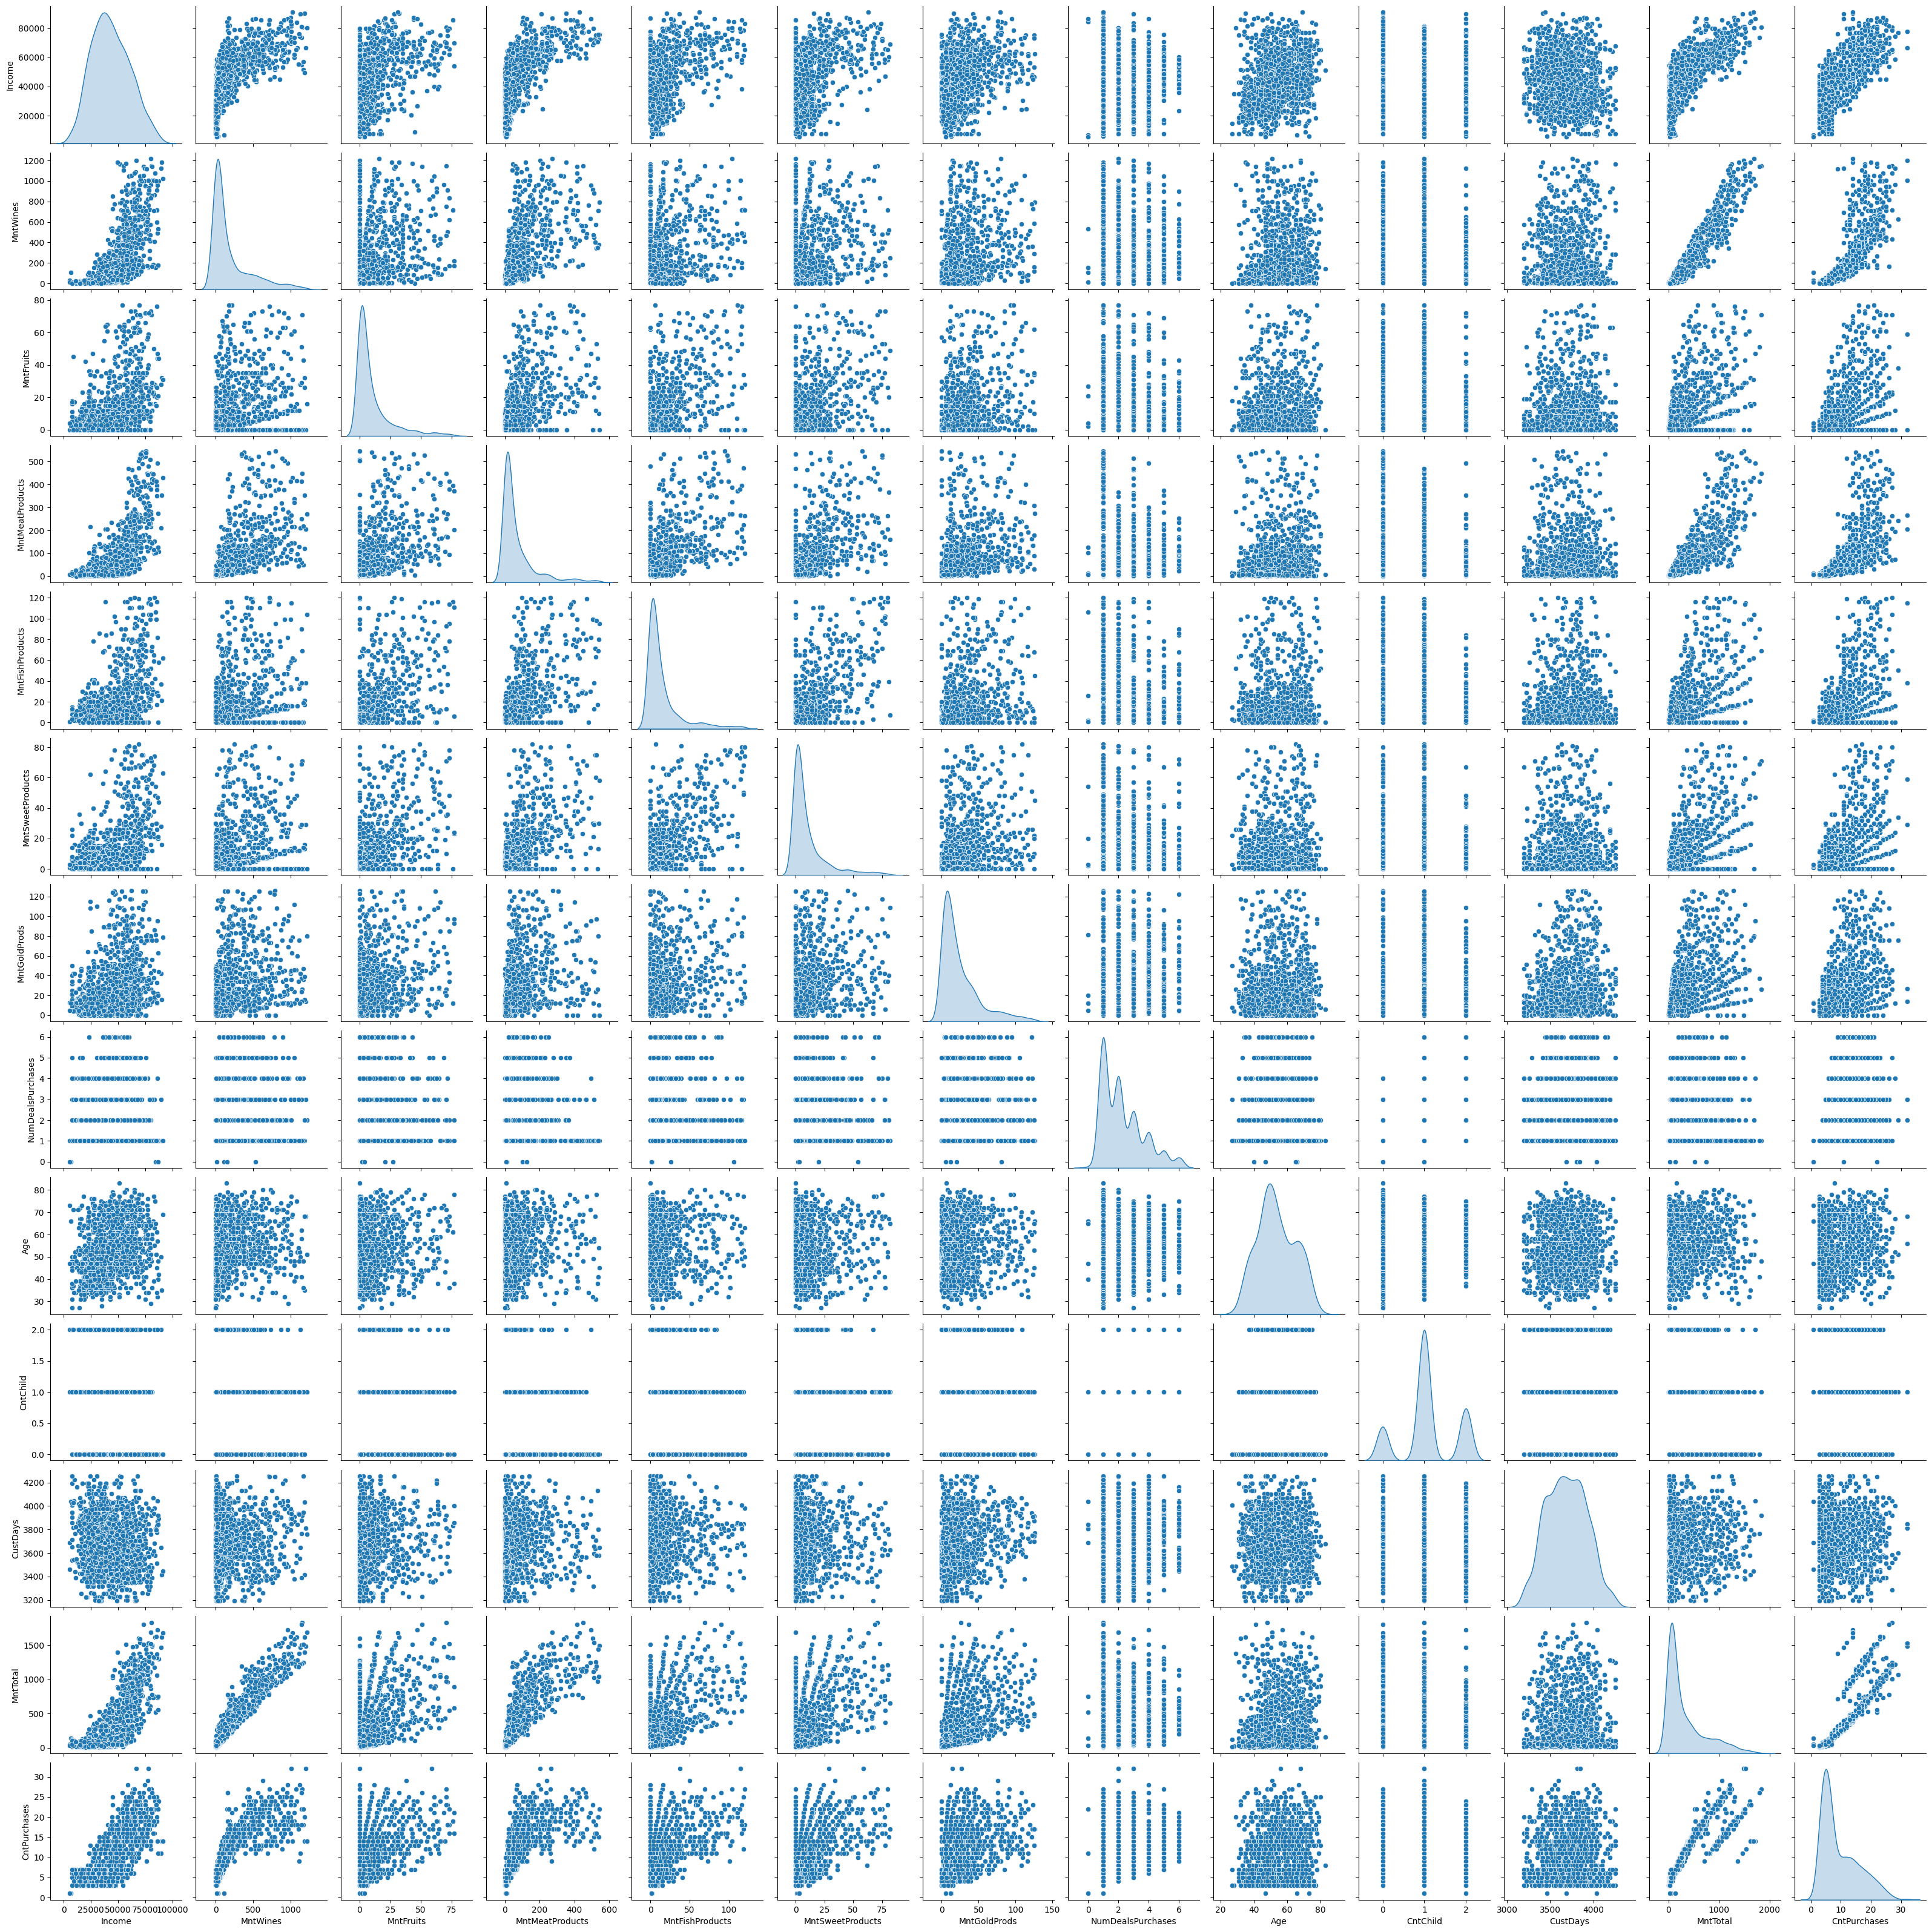

In [7]:
# Plot all selected features
sns.pairplot(df_cust_clean, diag_kind="kde")

<AxesSubplot:>

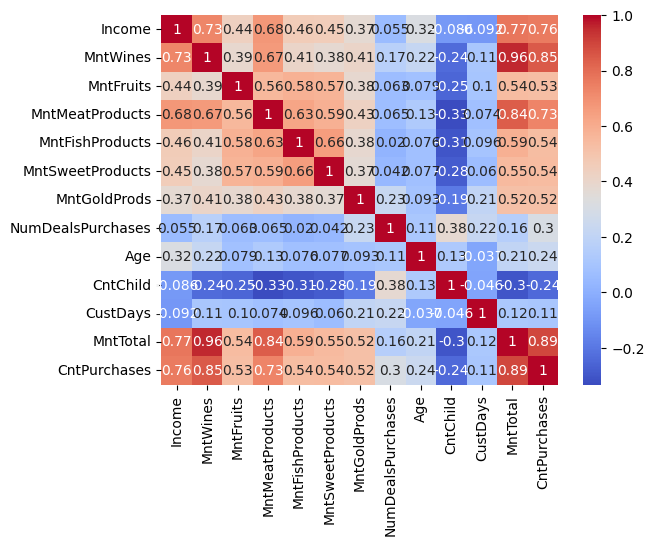

In [8]:
# Plot correlation matrix of selected features
sns.heatmap(df_cust_clean.corr(), cmap='coolwarm', annot=True)

## 4. Unsupervised ML models
### 4a. Prepare for clustering
- Perform clustering on 3 features: CustDays, CntPurchases, MntTotal (represent customer loyalty and behavioural actions)
- Perform standard scaling on the 3 features
- Find the optimal number of clusters based on Within-Cluster Sum of Squares (WCSS) an "Elbow Method" which quantifies how far the data points within a cluster are from the centroid of that cluster. A lower inertia value indicates that data points within a cluster are closer to the centroid.

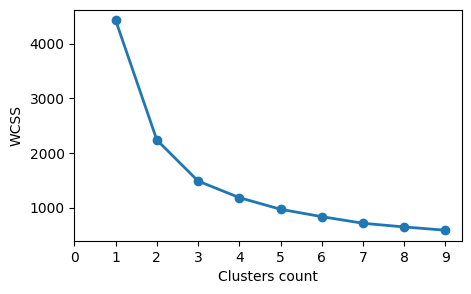

In [9]:
cols_cluster = ["CustDays", "CntPurchases", "MntTotal"]
df_cust_clust = df_cust_clean[cols_cluster]
scaler = StandardScaler()
df_cust_clust_scaled = scaler.fit_transform(df_cust_clust)

# Find the optimal cluster count
WCSS = []
rng = range(1, 10)
for i in rng:
    model = KMeans(n_clusters=i, init='k-means++')
    model.fit(df_cust_clust_scaled)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize=(5,3))
plt.plot(rng, WCSS, linewidth=2, marker='o')
plt.xticks(np.arange(10))
plt.xlabel("Clusters count")
plt.ylabel("WCSS")
plt.show()

### 4b. Create cluster models and visualize

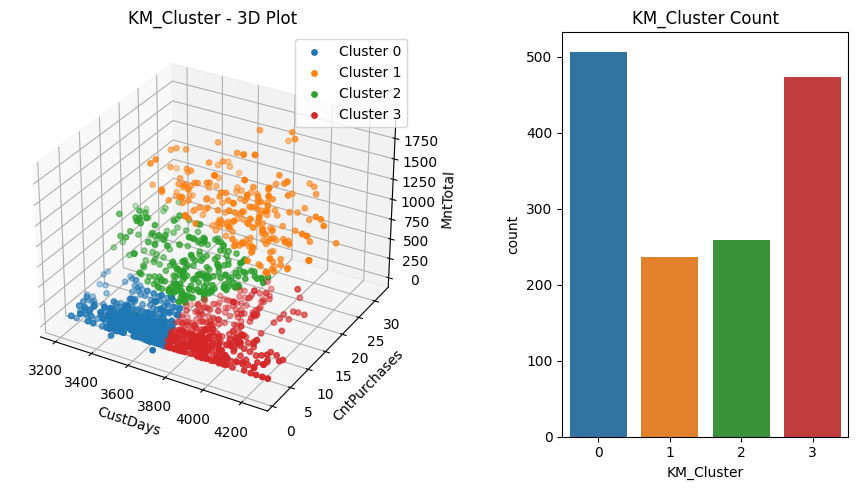

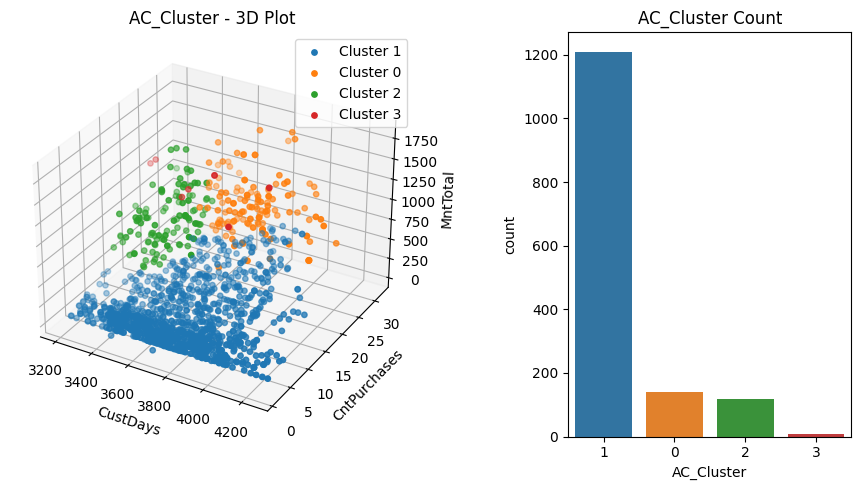

In [10]:
# Based on the WCSS set number of clusters
n_cluster = 4

# Create cluster dataframe
df_cluster = pd.DataFrame()

# Create cluster models
model_names = ['KM_Cluster', 'AC_Cluster']
km_model = KMeans(n_clusters=n_cluster, random_state=42)
df_cust_clean[model_names[0]] = km_model.fit_predict(df_cust_clust_scaled)
# After many experiements the below hyperparameters are the best.
ac_model = AgglomerativeClustering(n_clusters=n_cluster, linkage='average', affinity='euclidean')
df_cust_clean[model_names[1]] = ac_model.fit_predict(df_cust_clust_scaled)

# Plot the cluster
for mn in model_names:
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3])
    ax1 = fig.add_subplot(gs[0], projection='3d')
    l_clusters = df_cust_clean[mn].unique()
    for cluster in l_clusters:
        df = df_cust_clean[df_cust_clean[mn] == cluster]
        ax1.scatter(df['CustDays'], df['CntPurchases'], df['MntTotal'], s=15, label=f'Cluster {cluster}')
    ax1.set_xlabel('CustDays')
    ax1.set_ylabel('CntPurchases')
    ax1.set_zlabel('MntTotal')
    ax1.legend()
    ax1.set_title(f'{mn} - 3D Plot')
    ax2 = fig.add_subplot(gs[1])
    sns.countplot(x=df_cust_clean[mn], ax=ax2, order=l_clusters)
    ax2.set_title(f'{mn} Count')
    plt.tight_layout()
    plt.show()


### 4c. Evaluate the cluster models
Evaluate the cluster models using heuristic measures such as silhouette score which measures how similar each data point in one cluster is to other data points in the same cluster compared to other clusters. It ranges from -1 (poor clustering) to +1 (perfect clustering).

In [11]:
# Evalute the cluster models
s_score_km = silhouette_score(df_cust_clust_scaled, df_cust_clean[model_names[0]])
print("K-Means Silhouette Score:", s_score_km)
s_score_ac = silhouette_score(df_cust_clust_scaled, df_cust_clean[model_names[1]])
print("Agglomerative Clustering Silhouette Score:", s_score_ac)

# Set the cluster field to the best cluster model result.
# Agglomerative Clustering does not capture the clusters properly.
df_cust_clean['Cluster'] = df_cust_clean[model_names[0]]
# Drop the individual cluster model results
df_cust_clean = df_cust_clean.drop(columns=model_names)

K-Means Silhouette Score: 0.39926610881829444
Agglomerative Clustering Silhouette Score: 0.3859858583577374


### 4d. Analyze the clusters

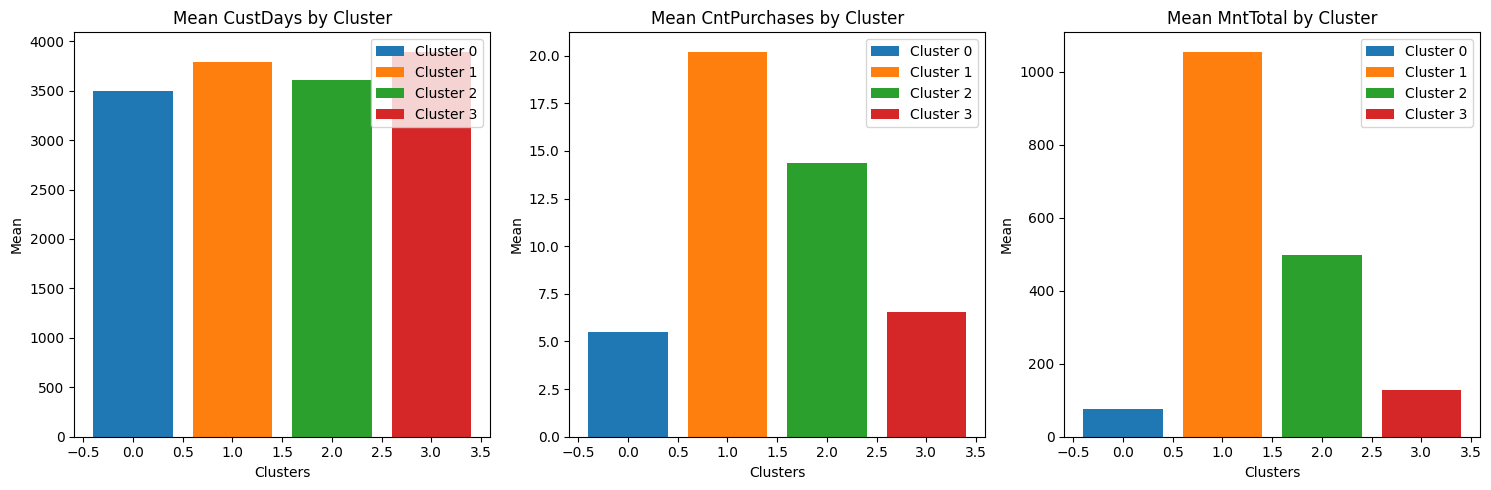

In [12]:
# Plot the clusters against the source features
cluster_labels = df_cust_clean["Cluster"].unique()
fig, axes = plt.subplots(1, len(cols_cluster), figsize=(15, 5))
for i, col in enumerate(cols_cluster):
    ax = axes[i]
    for label in cluster_labels:
        cluster_data = df_cust_clean[df_cust_clean["Cluster"] == label]
        cluster_mean = cluster_data[col].mean()
        # print(f'Cluster {label} - Feature {col} mean = {cluster_mean}')
        ax.bar(label, cluster_mean, label=f"Cluster {label}")
    ax.set_xlabel("Clusters")
    ax.set_ylabel(f"Mean")
    ax.set_title(f"Mean {col} by Cluster")
    ax.legend()
plt.tight_layout()
plt.show()

Based on the above plots, the clusters can be profiled as:

0. Customers in this cluster have moderate-term relationships with the company. On average they make approx. 5 purchases with total purchase amount of approx. $75.00, suggesting low frequent buyers and very low spender.
1. Customers in this cluster have moderate-term relationships with the company. On average they make approx 20 purchases with total purchase amount of approx. $1,054.00, suggesting frequent buyers and generous spender.
2. Customers in this cluster have moderate-term relationships with the company. On average they make approx 14 purchases with total purchase amount of approx. $498.00, suggesting moderate frequent buyers and moderate spender.
3. Customers in this cluster have moderate-term relationships with the company. On average they make approx 6 purchases with total purchase amount of approx. $127.00, suggesting low frequent buyers and low spender.

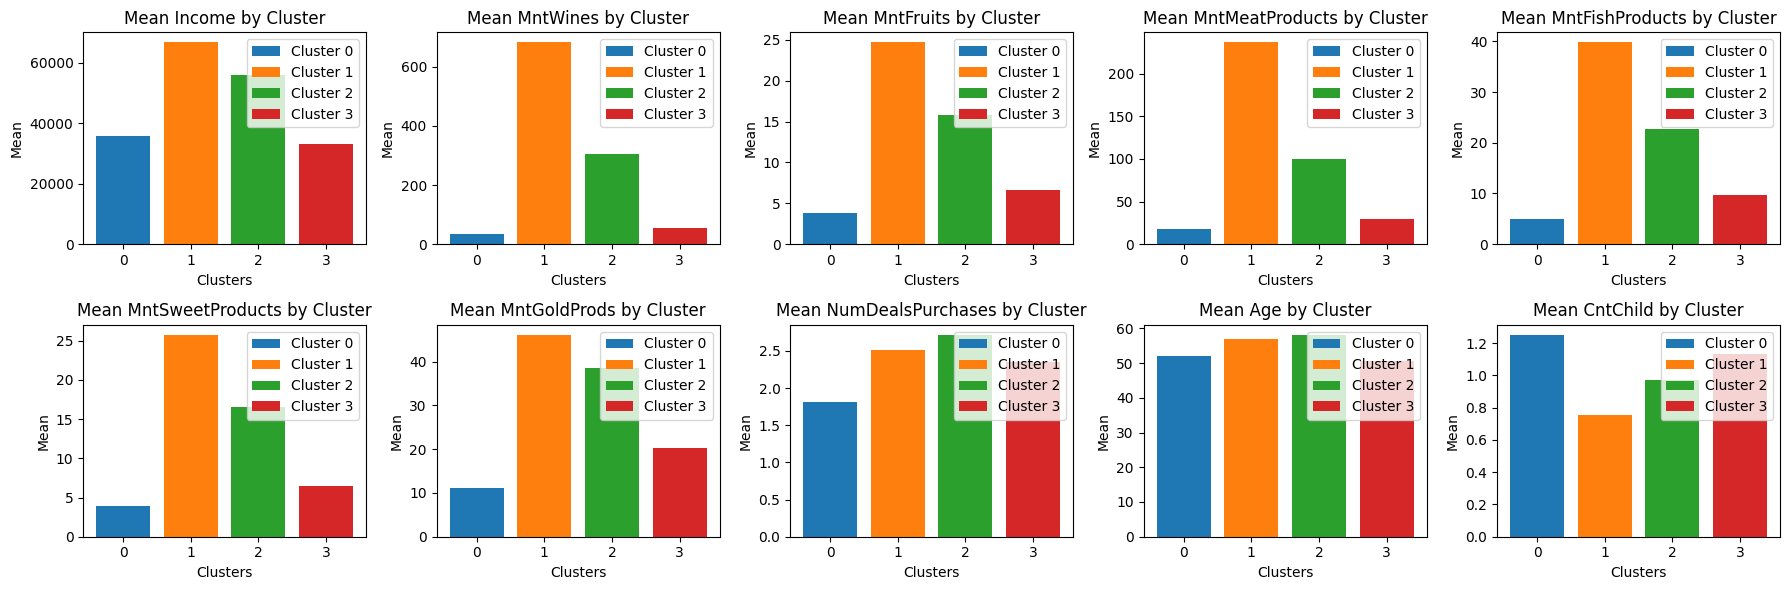

In [13]:
# Plot other numerical features against the clusters
cluster_labels = df_cust_clean["Cluster"].unique()
sel_columns = ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
               'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'Age', 'CntChild']
len_sel_columns = len(sel_columns)
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
c, r = 0, 0
for i, col in enumerate(sel_columns):
    if c > 4:
        c, r = 0, 1
    ax = axes[r, c]
    c += 1
    for label in cluster_labels:
        cluster_data = df_cust_clean[df_cust_clean["Cluster"] == label]
        cluster_mean = cluster_data[col].mean()
        # print(f'Cluster {label} - Feature {col} mean = {cluster_mean}')
        ax.bar(label, cluster_mean, label=f"Cluster {label}")
        ax.set_xlabel("Clusters")
        ax.set_ylabel(f"Mean")
        ax.set_title(f"Mean {col} by Cluster")
        ax.legend()
plt.tight_layout()
plt.show()


Based on the above plots, the cluster profiles can be adjusted / extended as follows:

0. Customers in this cluster have moderate-term relationships with the company. On average they make approx. 5 purchases with total purchase amount of approx. $75.00, suggesting low frequent buyers and very low spender. Their demographic profile having a moderate mean income, is mature which includes a mean age of 51 years and a child count of approx. 1.2.
1. Customers in this cluster have moderate-term relationships with the company. On average they make approx 20 purchases with total purchase amount of approx. $1,054.00, suggesting frequent buyers and generous spender. Their demographic profile having a high mean income, is mature which includes a mean age of 56 years and a child count of approx. 0.7.
2. Customers in this cluster have moderate-term relationships with the company. On average they make approx 14 purchases with total purchase amount of approx. $498.00, suggesting moderate frequent buyers and moderate spender. Their demographic profile having a high mean income, is mature which includes a mean age of 57 years and a child count of approx. 0.9.
3. Customers in this cluster have moderate-term relationships with the company. On average they make approx 6 purchases with total purchase amount of approx. $127.00, suggesting low frequent buyers and low spender. Their demographic profile having a moderate mean income, is mature which includes a mean age of 51 years and a child count of approx. 1.1.

### 4e. Conclusion

Based on the model evaluation Silhouette Scores, both K-Means and Agglomerative Clustering (AC) have generated clusters with similar low scores and different clusters quality, AC having 1 cluster almost non existant.
The generated K-Means clusters represent customers with moderate-term relationships with the company, but they exhibit different purchasing behaviors and demographic characteristics:
- Cluster 1 stands out as a group of frequent buyers with a high total purchase amount, likely representing a generous-spending demographic. 
- Clusters 0, 2, and 3 exhibit lower purchase frequencies and spending levels, indicating a more budget-conscious customer base.

In summary, the company has a customer base consisting mostly of mature individuals with moderate-term relationships. However the company can focus its marketing efforts not only on Cluster 1 to maximize revenue, while also considering tailored strategies for Clusters 0, 2, and 3 to encourage higher spending and more frequent purchases.